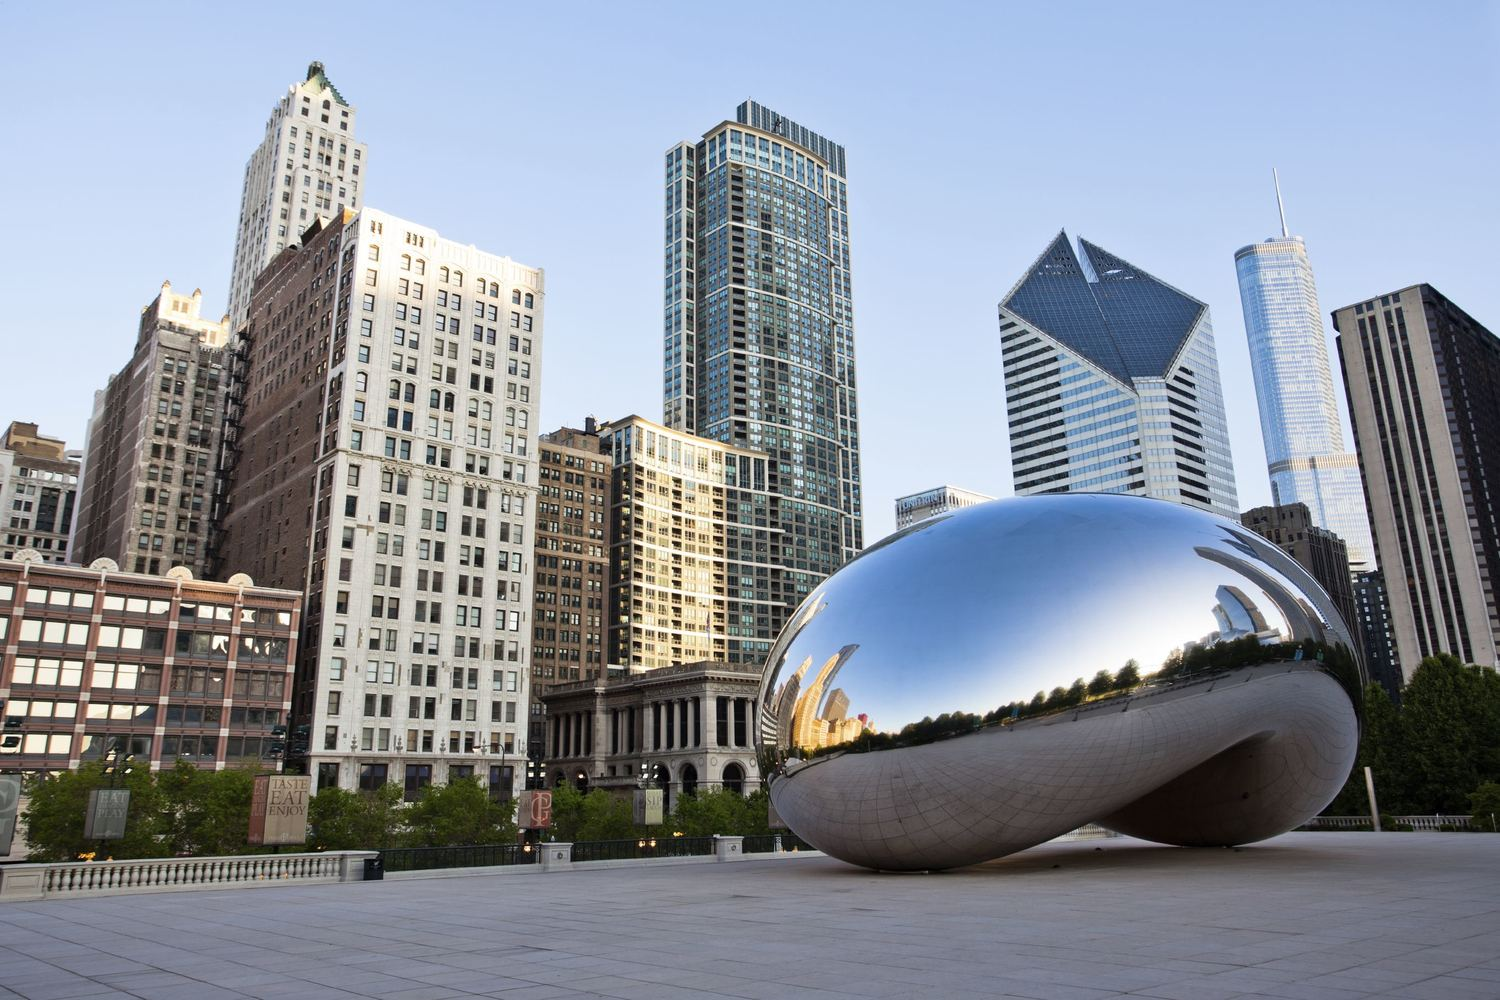

# Curbing Chicago Car Crashes

**Authors:** Carlos McCrum, Michael Lee, Doug Mill
***

## Overview

Our task is to build inferential classification models for the Vehicle Safety Board of Chicago. We cleaned and formatted our data provided by the City of Chicago containing crashes,  vehicles and people relating to crashes from 2016 to 2020, we then modeled the primary contributory causes of car accidents into two categories. We used an iterative modeling approach and incorporated several classification models to see if we could find what crashes were preventable. Our recommendations include investing in driver education for certain age groups and fixing certain road conditions that could cause a crash. 
***

## Business Problem

Vehicle Safety Board wants to know if they should spend more funding in drivers education or fixing roads. Determining whether a crash is preventable and how to allocate funds to limit the number of crashes to present to the Vehicle Safety Board of Chicago.


***

## Data Understanding

Our stakeholder is the Vehicle Safety Board of Chicago. They are launching a new campaign to reduce car crashes. Our task is to build an inferential model to find out  which crashes were preventable and not. We labeled ‘Preventable’ as crashes that could have easily been avoided. Not following traffic laws and negligent driving would fall under this category. ‘Less Preventable’ are crashes that would require a substantial amount of money, time, and labor to fix. Bad road conditions, vision obscurity, and bad weather conditions would fall under this category.
***

##### Start by importing necessary packages. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

***

## Model Preparation

Import data previously cleaned with only the relevant columns we need for our analysis. Our variable is a binary target that points to the contributory cause of the crash either being preventable or non-preventable.

***


Import our cleaned dataframe we cleaned previously. 

In [2]:
main_df = pd.read_csv('data/cleaned_data/cleaned_modeling_data.csv')
columns_to_drop = ['Unnamed: 0']
main_df.drop((columns_to_drop), axis = 1, inplace = True)

Check to see if we have a class imbalance. 

In [3]:
main_df['Target'].value_counts(normalize = True)

0    0.754374
1    0.245626
Name: Target, dtype: float64

Check correlations with our target


## Data Modeling
We modeled the data through iterative modeling. We used a logistic regression model as our first simple model. For our second model, we created a Decision Tree Classifier that scored slightly better than our simple model. We used a RFE to determine the most important features and iterated with GridSearch to find the best parameters. Lastly, we used a XGBoost classifier with GridSearchCV to find the best model.
***

## Simple Model - Logistic Regression

To measure our model performance, we will be using precision and accuracy to see how well our model is performing. 
Since we are creating a inferential model, correctly classifiying the target category correctly should be the main priority. Precision is a good metric because we want to know how many true positives our model is getting right, accuracy is good too becuase it tells how many true positives and true negetives our model is getting right overall. 



$$ \text{Precision} = \frac{\text{Number of True Positives}}{\text{Number of Predicted Positives}} $$    
$$ \text{Accuracy} = \frac{\text{Number of True Positives + True Negatives}}{\text{Total Observations}} $$

To run our first simple model we start off by dropping irrelevant columns. 

In [4]:
columns_to_drop = ['CRASH_RECORD_ID','CRASH_DATE', 'LONGITUDE', 'LATITUDE', 'Target']

Split our data with train test split 

In [5]:
X = main_df.drop((columns_to_drop), axis=1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Initiate logistic regression model
- fit model
- print coefficients , y-intercept
- print summary

In [6]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [7]:
print(logreg.coef_, logreg.intercept_)

[[ 0.12988649  0.20098016  0.822363    1.42466443 -0.44294368 -0.07022554
   0.45626927 -0.40778448  0.90737109 -2.07794228]] [-0.69633504]


In [8]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
X = add_constant(X)
print(Logit(y, X).fit().summary())

Optimization terminated successfully.
         Current function value: 0.481552
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:               952140
Model:                          Logit   Df Residuals:                   952129
Method:                           MLE   Df Model:                           10
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                  0.1362
Time:                        23:37:25   Log-Likelihood:            -4.5851e+05
converged:                       True   LL-Null:                   -5.3080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.6939      0.005   -143.200      0.000      -0.703      

Based on the coefficients generated from our model, it seems like 'Defect_Road' has the highest odds of happening at around 3x when compared to other factors.

This means that we can cut down on the impact of 'Defect_Roads' to mitigate crashes. So, perhaps some funding in road fixtures would be a good idea.

In [9]:
print('Training Accuracy: ', logreg.score(X_train, y_train))
print('Training Precision: ', precision_score(y_train, logreg.predict(X_train)))

Training Accuracy:  0.7467543288451979
Training Precision:  0.4465392714462834


Our model seems to be pretty good at classifying if a crash was easily preventable or less preventable. However, we wanted to explore if a DecisionTreeClassifier or XGBoost would give us a better accuracy score.

## Using RFE to select the most important columns

In order to determine the most important features, we used the RFE tool with the DecisionTreeClassifier.

In [10]:
# Instantiate classifier and parameters for model accessibility
dt = DecisionTreeClassifier()
num_features_to_select = 5

select = RFE(dt, n_features_to_select=num_features_to_select)
select.fit(X = X_train, y = y_train)

# Create a list of the most important features
keep_list = [(k,v) for k,v in zip(main_df.drop((columns_to_drop), axis=1).columns,select.support_)]
keep_string = "'"
for k,v in keep_list:
    if v:
        keep_string += k + "','"
keep_string = keep_string[:-2]

keep_string

"'BAD_ROAD_CONDITION','DEFECT_ROAD','WORKING_TRAFFIC_DEVICE','OBSCURED_VIZ','DRIVER_ERROR'"

To reduce noise, we only included the top 5 features to see if we can get a better precision score.

In [11]:
X = main_df.drop((columns_to_drop), axis = 1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
print('Training Accuracy: ', dt.score(X_train, y_train))
print('Training Precision: ', precision_score(y_train, dt.predict(X_train)))

Training Accuracy:  0.757335405857682
Training Precision:  0.5994588636135886


The ROC_AUC score isn't bad... but it definately seems improvable.

In [12]:
y_pred = dt.predict(X_test)
roc_auc_score(y_pred, y_test)

0.6739770332807699

In [13]:
X = main_df[['BAD_VISIBILITY','BAD_TRAFFIC','BAD_ROAD_CONDITION','DEFECT_ROAD','WORKING_TRAFFIC_DEVICE']]
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt_rfe = DecisionTreeClassifier(random_state = 42)
dt_rfe.fit(X_train, y_train)
print('Training Accuracy: ', dt_rfe.score(X_train, y_train))
print('Training Precision: ', precision_score(y_train, dt_rfe.predict(X_train)))

Training Accuracy:  0.7556675838987263
Training Precision:  0.6308503625576797


A 2% increase is not a bad start, but ideally we want the highest number possible.

In [14]:
y_pred = dt_rfe.predict(X_test)
roc_auc_score(y_pred, y_test)

0.692434942857998

Success! We increased our our precision by 4% by only including the features the RFE output. Below is the confusion matrix plot of the training and test set.

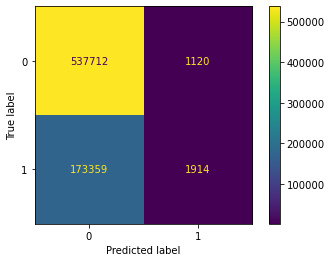

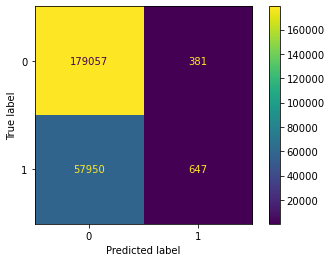

In [15]:
plot_confusion_matrix(dt_rfe, X_train, y_train), plot_confusion_matrix(dt_rfe, X_test, y_test);

Awsome! Our DecisionTreeClassifier is doing better than the LogisticRegression model. However, it does not seem to be by much. Lets see if we can find the best parameters for the DecisionTreeClassifier using GridSearch

# Grid Search

Because Decision Trees gave us the best combination of precision and accuracy, we decided to try and find the best parameters
Using Grid Search.

Fit to our grid
- Analyze the results
- See what the best perameters are
- Find our best score

To reduce training time, we split the grid search into parts.

In [16]:
grid = [{'max_depth': [2, 4, 6], 
         'min_samples_split': [1, 5, 10], 
         'min_samples_leaf': [5, 10, 15]}]
GS = GridSearchCV(estimator=dt_rfe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)
GS.fit(X_train, y_train)
GS.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 5}

In [17]:
grid = [{'max_depth': [6, 7, 8], 
         'min_samples_split': [4, 5, 6], 
         'min_samples_leaf': [4, 5, 6]}]
GS = GridSearchCV(estimator=dt_rfe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)
GS.fit(X_train, y_train)
GS.best_params_

{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 4}

In [18]:
grid = [{'max_depth': [6], 
         'min_samples_split': [4, 5], 
         'min_samples_leaf': [2, 3, 4]}]
GS = GridSearchCV(estimator=dt_rfe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)
GS.fit(X_train, y_train)
GS.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4}

In [19]:
grid = [{'max_depth': [6], 
         'min_samples_split': [4, 5], 
         'min_samples_leaf': [1, 2]}]
GS = GridSearchCV(estimator=dt_rfe, 
                          param_grid=grid, 
                          scoring='accuracy', 
                          cv=5)
GS.fit(X_train, y_train)
GS.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4}

In [20]:
GS.cv_results_

{'mean_fit_time': array([0.13942714, 0.13723311, 0.13842978, 0.13723316]),
 'std_fit_time': array([0.00298568, 0.00232583, 0.00317865, 0.00249124]),
 'mean_score_time': array([0.01436133, 0.01356363, 0.01356349, 0.0139626 ]),
 'std_score_time': array([1.35241651e-03, 4.88908814e-04, 4.88791781e-04, 2.43140197e-07]),
 'param_max_depth': masked_array(data=[6, 6, 6, 6],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 1, 2, 2],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[4, 5, 4, 5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4},
  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5},
  {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4

In [21]:
print('Test Precision: ', precision_score(y_test, GS.best_estimator_.predict(X_test)))
print('Test Accuracy: ', GS.best_estimator_.score(X_test, y_test))

Test Precision:  0.6293774319066148
Test Accuracy:  0.7549478017938538


Unfortunately, after all that, we still had a relatively similar ROC_AUC score as the Decision Tree Classifier

In [22]:
y_pred = GS.predict(X_test)
roc_auc_score(y_pred, y_test)

0.692434942857998

The Grid Search gave us the optimal parameters for the DecisionTreeClassifier, and it seems to do slightly better than the DecisionTree with default parameters.

## XGBoost

- Initiate XGBClassifier, fit, and determine the training and validation scores. 

In [23]:
clf = XGBClassifier(eval_metric='mlogloss')
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('')

# Precision
training_precision = precision_score(y_train, training_preds)
test_precision = precision_score(y_test, test_preds)
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))

Training Accuracy: 75.57%
Validation accuracy: 75.49%

Training Precision: 63.09%
Validation Precision: 62.94%


In [24]:
clf.score(X_test, y_test)

0.7549478017938538

In [25]:
# Test different parameters 
param_grid = {
    'learning_rate': [0.2, 0.5],
    'max_depth': [6],
    'min_child_weight': [1],
    'subsample': [0.7],
    'n_estimators': [100, 200],
}


In [26]:
# Utilitze GridSearch to find best parameters
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('')

training_precision = precision_score(y_train, training_preds)
test_precision = precision_score(y_test, test_preds)
print('Training Precision: {:.4}%'.format(training_precision * 100))
print('Validation Precision: {:.4}%'.format(test_precision * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7
Training Accuracy: 75.57%
Validation accuracy: 75.49%

Training Precision: 63.09%
Validation Precision: 62.94%


And with the XG Boost with Grid Search producing comparable results to the XG Boost with default parameters, we decided to leave it at that.

In [27]:
y_pred = grid_clf.predict(X_test)
roc_auc_score(y_pred, y_test)

0.692434942857998

In [28]:
grid_clf.score(X_test, y_test)

0.7549478017938538

Well, that model took long to run, but we seem to have a winner. Based on the precision and accuracy scores of our models, the XGBoost performs the best.

## Results

Our final model performed fairly well with good accuracy and precision. The results of our model indicated that most of the crashes were Preventable 
***

## Evaluation
Our buisness problem was to find out what crashes were preventalbe or were not preventable and to find recommendations for Vehicle Safety Board. Testing our models with both percision and accuracy becuase we want to know how many true positives our model got right and cut down on the consequences of errors. In combination with recursive feature elimination and running our models on the relevent variables, we now have good insight on what to recommend using our inferential model. By spending more money on drivers education in ages 20 - 39, we could curb the total accidents in Chicago drastically. This would be an efficient and effective use of funds for the Vehicle Safety Board of Chicago. In addition, fixing roads that may be cause for crashes that were not preventable would be beneficial. 

### Data Limitations
Some categories in our data were recorded by the officer at the scene as 'not determined', which sets limitations in our model. Some other limitations include lack of economic data or public transportation data.
The 'Other' column had a lot of obscured vision as the primary cause but that could mean anything between reflective sunlight to a tree branch, so it would be better to have deeper that in that.
***

## Conclusions

We recommend fixing damaged or defect roads focusing on the hot spot areas that have more less preventable crashes, along with investing in an online driver and behavior education campaign because this could significantly lower the amount of preventable crashes in the Chicago area. We recommend driver education because it is affordable, easy to implement, and saves a lot more in labor costs than just repairing damaged roads in Chicago. We also suggest that the driver education campaign target a younger audience between 20-39. It would be most effective to market it to these folks as they comprised roughly 49.2% of drivers involved in crashes that were preventable.
***